In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

from keras.applications.vgg16 import VGG16 # load VGG16 model from keras
from keras.preprocessing.image import load_img # Using images library
from keras.preprocessing.image import img_to_array # # convert image pixels to numpy for specific manipulations
from keras.applications.vgg16 import preprocess_input # to prepare for new input
from keras.applications.vgg16 import decode_predictions # for reporting probabilities

Using TensorFlow backend.


In [2]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# prepare an iterators for each dataset
train_it = train_datagen.flow_from_directory('data/images/train',
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     batch_size=32,
                                     class_mode='categorical',
                                     shuffle=True)

validate_it = train_datagen.flow_from_directory('data/images/validate',
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     batch_size=32,
                                     class_mode='categorical',
                                     shuffle=True)

train_batchX, train_batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (train_batchX.shape, train_batchX.min(), train_batchX.max()))
validate_batchX, validate_batchy = validate_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (validate_batchX.shape, validate_batchX.min(), validate_batchX.max()))

Found 225 images belonging to 5 classes.
Found 48 images belonging to 5 classes.
Batch shape=(32, 224, 224, 3), min=-123.680, max=151.061
Batch shape=(32, 224, 224, 3), min=-123.680, max=151.061


In [3]:
# classifying only weapons 
vgg16_model = VGG16(weights="imagenet")

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation

seq_model = Sequential()

# iterate all layers in vgg16 to sequential for custom modification
for layer in vgg16_model.layers:
    seq_model.add(layer)
    
seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [5]:
# 1000 categories, pop off output layer to work only specific categories
seq_model._layers.pop()

In [6]:
# freeze weights to prevent constantly updating weights
for layer in seq_model._layers:
    layer.trainable = False

In [7]:
seq_model.add(Dense(5, activation='softmax')) # 5 categories 

# seq_model.summary()

In [8]:
seq_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train = train_it.n//train_it.batch_size
history = seq_model.fit_generator(generator=train_it,
                                  validation_data=validate_it,
                                  validation_freq=1,
                                  steps_per_epoch=step_size_train,
                                  shuffle=True,
                                  epochs=50)

Epoch 1/50
7/7 [==============================] - 6s 889ms/step - loss: 1.5913 - accuracy: 0.3472 - val_loss: 1.6040 - val_accuracy: 0.3333
Epoch 2/50
7/7 [==============================] - 2s 232ms/step - loss: 1.5413 - accuracy: 0.7047 - val_loss: 1.6045 - val_accuracy: 0.2917
Epoch 3/50
7/7 [==============================] - 2s 219ms/step - loss: 1.5327 - accuracy: 0.8187 - val_loss: 1.6213 - val_accuracy: 0.2708
Epoch 4/50
7/7 [==============================] - 2s 257ms/step - loss: 1.5076 - accuracy: 0.9107 - val_loss: 1.6090 - val_accuracy: 0.2292
Epoch 5/50
7/7 [==============================] - 2s 224ms/step - loss: 1.4854 - accuracy: 0.9074 - val_loss: 1.6038 - val_accuracy: 0.2917
Epoch 6/50
7/7 [==============================] - 2s 255ms/step - loss: 1.4837 - accuracy: 0.8795 - val_loss: 1.6000 - val_accuracy: 0.1667
Epoch 7/50
7/7 [==============================] - 2s 256ms/step - loss: 1.4641 - accuracy: 0.9171 - val_loss: 1.6019 - val_accuracy: 0.2708
Epoch 8/50
7/7 [====

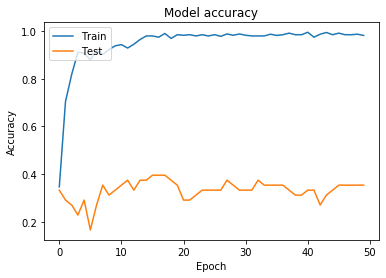

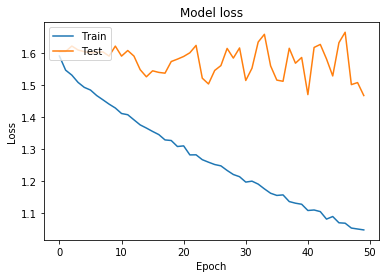

In [9]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
# TO PREDICT PROPERLY YOU NEED TO FEED IT AN IMAGE THAT IS NOT IN THE VALIDATION OR TEST!
prediction = seq_model.predict(validate_batchX)

# convert the probabilities to class labels
#label = decode_predictions(pred)

for row in range(len(prediction)):
    biggest = np.argmax(prediction[row])
    for val in range(len(prediction[row])):
        if(val == biggest):
            prediction[row][val] = 1.
        else:
            prediction[row][val] = 0.

# retrieve the most likely result, e.g. highest probability
test_prediction = prediction == validate_batchy

In [26]:
# HOW MANY OF THE TESTS WERE WRONG
print((np.sum(test_prediction % 2 == 0))/2)

20.0
